In [ ]:
import os
import shutil
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
wordnet_lemmatizer = WordNetLemmatizer()
#import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import PIL
from PIL import Image
import urllib.request
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.utils import to_categorical
from keras.preprocessing import image

from tqdm import tqdm
from keras.models import load_model, Model
from pathlib import Path


In [ ]:
pd.set_option('display.max_rows',None)
train=pd.read_csv(r'train.csv')
train=train.replace(np.nan, '',regex=True)
val=pd.read_csv(r'validation.csv')
val=val.replace(np.nan, '',regex=True)
test=pd.read_csv(r'newtestdata1.csv')
test=test.replace(np.nan, '',regex=True)

In [ ]:

punctuaions=set(string.punctuation)

#inputs
X_text_train=train['title'].map(str)+' '+train['description'].map(str)
X_text_val=val['title'].map(str)+' '+val['description'].map(str)
X_text_test=test['title'].map(str)+' '+test['description'].map(str)
#outputs
y_text_train=train['categories__2'].values
y_text_test=test['categories__2'].values
y_text_val=val['categories__2'].values
y_text_val=[x.lower() for x in y_text_val ]
y_text_train=[x.lower() for x in y_text_train ]
y_text_test=[x.lower() for x in y_text_test ]


In [ ]:
def leafnode_extraction(data_frame):
    leafnode=[]
    for index,col in data_frame.iterrows():
        if len(col['categories__6'])!=0:
            leafnode.append(col['categories__6'])
        elif len(col['categories__5'])!=0:
            leafnode.append(col['categories__5'])
        elif len(col['categories__4'])!=0:
            leafnode.append(col['categories__4'])
        elif len(col['categories__3'])!=0:
            leafnode.append(col['categories__3'])
        else:
            leafnode.append(col['categories__2'])
    return leafnode



#feature extraction
def tf_idf_vectorization(inp,test,val):
    X_train_tfidf=[]
    X_new_tfidf=[]
    X_val_tfidf=[]
    tfidf_vect1=TfidfVectorizer(max_features=5000)
    tfidf_vect1.fit(inp['final_lemmatized_string'])
    X_train_tfidf = tfidf_vect1.transform(inp['final_lemmatized_string'])
    X_new_tfidf = tfidf_vect1.transform(test['final_lemmatized_string'])
    X_val_tfidf = tfidf_vect1.transform(val['final_lemmatized_string'])
    print(X_train_tfidf.shape)
    print(X_new_tfidf.shape)
    return  X_train_tfidf,X_new_tfidf,X_val_tfidf
def create_model(dims,n):
    model=Sequential()
    model.add(Dense(512, input_dim=dims[1],activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(n, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}','&','nan'])
stemmer = SnowballStemmer('english')
#processed_train = []


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
#Preprocess the text in training and testing dataset stemming and lemmatizing
lemmatized_train =[]
lemmatized_test=[]
lemmatized_val=[]

for doc in X_text_train:
    tokens = word_tokenize(doc)
    tokens=[w.lower() for w in tokens if w.isalpha()]
    filtered = [word for word in tokens if word not in stop_words]
    lemmatized=[wordnet_lemmatizer.lemmatize(word) for word in filtered]
    lemmatized_train.append(lemmatized)

for doc in X_text_test:
    tokens = word_tokenize(doc)
    tokens=[w.lower() for w in tokens if w.isalpha()]
    filtered = [word for word in tokens if word not in stop_words]
    lemmatized=[wordnet_lemmatizer.lemmatize(word) for word in filtered]
    lemmatized_test.append(lemmatized)


for doc in X_text_val:
    tokens = word_tokenize(doc)
    tokens=[w.lower() for w in tokens if w.isalpha()]
    filtered = [word for word in tokens if word not in stop_words]
    lemmatized=[wordnet_lemmatizer.lemmatize(word) for word in filtered]
    lemmatized_val.append(lemmatized)
#print(lemmatized_train[1])
train['lemmatized_text']=lemmatized_train
test['lemmatized_text']=lemmatized_test
val['lemmatized_text']=lemmatized_val


# Converting array to string
row_lst1 =[]
for lst in train.loc[:,'lemmatized_text']:
    text = ''
    for word in lst:
        text = text + ' ' + word
    row_lst1.append(text)
train['final_lemmatized_string']=row_lst1
#train.drop('final_stemmed_text',axis=1,inplace=True)
train.head()
row_lst1 =[]

for lst in test.loc[:,'lemmatized_text']:
    text = ''
    for word in lst:
        text = text + ' ' + word
    row_lst1.append(text)

test['final_lemmatized_string']=row_lst1
test.head()
row_lst1 =[]
for lst in val.loc[:,'lemmatized_text']:
    text = ''
    for word in lst:
        text = text + ' ' + word
    row_lst1.append(text)
val['final_lemmatized_string']=row_lst1
val.head()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,description,imUrl,price,brand,categories__1,categories__2,categories__3,categories__4,categories__5,categories__6,lemmatized_text,final_lemmatized_string
0,Cisco-Linksys EFAH05W EtherFast 10/100 5-Port ...,The EtherFast 5-Port 10/100 Auto-Sensing Hub f...,http://ecx.images-amazon.com/images/I/41JSBWRC...,79.0,,Electronics,Computers & Accessories,Networking Products,Hubs,,,"[etherfast, workgroup, hub, etherfast, hub, li...",etherfast workgroup hub etherfast hub linksys...
1,Nikon Coolpix 800 2MP Digital Camera w/ 2x Opt...,Nikon first brought 2-megapixel quality to the...,http://ecx.images-amazon.com/images/I/7183RBY6...,7.33,,Electronics,Camera & Photo,Digital Cameras,Point & Shoot Digital Cameras,,,"[nikon, coolpix, digital, camera, optical, zoo...",nikon coolpix digital camera optical zoom nik...
2,Aiwa XR-M75 Compact Stereo System (Discontinue...,With so many compact and mini stereos to choos...,http://ecx.images-amazon.com/images/I/41S6N954...,,,Electronics,Home Audio,Compact Stereos,,,,"[aiwa, compact, stereo, system, discontinued, ...",aiwa compact stereo system discontinued manuf...
3,Olympus Stylus Epic DLX 35mm Camera,Product Information\nIf you are passionate abo...,http://ecx.images-amazon.com/images/I/41R370QD...,,,Electronics,Camera & Photo,Film Photography,Film Cameras,Point & Shoot Film Cameras,,"[olympus, stylus, epic, dlx, camera, product, ...",olympus stylus epic dlx camera product inform...
4,JBL S310 3-Way Floorstanding Speaker (Single S...,"The JBL S310 is a 3-way, 10-inch floor-standin...",http://ecx.images-amazon.com/images/I/4184SSV9...,,,Electronics,Home Audio,Stereo Components,Speakers,Floorstanding Speakers,,"[jbl, floorstanding, speaker, single, speaker,...",jbl floorstanding speaker single speaker blac...


In [ ]:
#feature extraction
tfidf_vect=TfidfVectorizer(max_features=5000)
tfidf_vect.fit(train['final_lemmatized_string'])

X_train_tfidf = tfidf_vect.transform(train['final_lemmatized_string'])
X_new_tfidf = tfidf_vect.transform(test['final_lemmatized_string'])
X_new_val = tfidf_vect.transform(val['final_lemmatized_string'])



In [ ]:

# Encoding labels
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(y_text_train)
encoded_labels_train = to_categorical(encoded_labels_train)
encoded_labels_test = label_encoder.fit_transform(y_text_test)
encoded_labels_test = to_categorical(encoded_labels_test)
encoded_labels_val = label_encoder.fit_transform(y_text_val)
encoded_labels_val = to_categorical(encoded_labels_val)
print(encoded_labels_train.shape)

(3565, 11)


In [ ]:

# Build Denoising Autoencoder (DAE)
input_dim = X_train_tfidf.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dropout(0.5)(encoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
dae = Model(input_layer, decoded)
dae.compile(optimizer='adam', loss='binary_crossentropy')
dae.fit(X_train_tfidf.toarray(), X_train_tfidf.toarray(), epochs=65, batch_size=10, validation_data=(X_new_val.toarray(), X_new_val.toarray()))
#dae.save("encodelevel.h5")

In [ ]:

encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train_tfidf.toarray())
X_test_encoded = encoder.predict(X_new_tfidf.toarray())
X_val_encoded = encoder.predict(X_new_val.toarray())

16/16 [==============================] - 0s 2ms/step


In [ ]:
def train_denoising_autoencoder(X_train, X_new, X_new_val):
    # Build Denoising Autoencoder (DAE)
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dropout(0.5)(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    dae = Model(input_layer, decoded)
    dae.compile(optimizer='adam', loss='binary_crossentropy')
    dae.fit(X_train.toarray(), X_train.toarray(), epochs=50, batch_size=5, validation_data=(X_new_val.toarray(), X_new_val.toarray()))

    # Extract features using DAE
    encoder = Model(input_layer, encoded)
    X_train_encoded = encoder.predict(X_train.toarray())
    X_test_encoded = encoder.predict(X_new.toarray())
    X_val_encoded = encoder.predict(X_new_val.toarray())
    return X_train_encoded, X_test_encoded, X_val_encoded



To Download the images for the first time make changes to download train and test images as well


In [ ]:
#-----To download validation dataset images  Run only once to download images to local path----------

val_images=list(val['imUrl'])
X_images=[]
for i in tqdm(range(0,len(val_images))):
    img=Image.open(urllib.request.urlopen(val_images[i]))
    X_images.append(img)
print(len(val_images))
a=0
for i in X_images:
    if i.mode=='P':
        i=i.convert('RGB')
    b='C:/Users/sowjanya/Documents/RMTC_IMPLEMENTATION/code/final_modified_folder/val_images/'+str(a)+'.jpg'
    i.save(b)
    a=a+1

100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


500


**Extract Images from drive**

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/RMTC-08-04-24/train_images.zip'

# Directory to extract the contents to
extract_to_dir = '/content/train_images'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# List the extracted files
extracted_files = os.listdir(extract_to_dir)
print("Files extracted to:", extract_to_dir)
print("Extracted files:", extracted_files)



# Path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/RMTC-08-04-24/test_images.zip'

# Directory to extract the contents to
extract_to_dir = '/content/test_images'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# List the extracted files
extracted_files = os.listdir(extract_to_dir)
print("Files extracted to:", extract_to_dir)
print("Extracted files:", extracted_files)




# Path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/RMTC-08-04-24/val_images.zip'

# Directory to extract the contents to
extract_to_dir = '/content/val_images'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# List the extracted files
extracted_files = os.listdir(extract_to_dir)
print("Files extracted to:", extract_to_dir)
print("Extracted files:", extracted_files)

Mounted at /content/drive
Files extracted to: /content/train_images
Extracted files: ['train_images']
Files extracted to: /content/test_images
Extracted files: ['test_images']
Files extracted to: /content/val_images
Extracted files: ['val_images']


In [ ]:
X_Train_Images=[]
X_Test_Images=[]
for i in tqdm(range(test.shape[0])):
    img=image.load_img('test_images/test_images/'+str(i)+'.jpg',target_size=(200,200,3))
    img=image.img_to_array(img)
    img=img/255
    X_Test_Images.append(img)
X_test_img=np.array(X_Test_Images)
lst=[]
for i in range(train.shape[0]):
    img='train_images/train_images/'+str(i)+'.jpg'
    lst.append(img)
#print(lst)
train['image']=lst
lst=[]
for i in range(test.shape[0]):
    img='test_images/test_images/'+str(i)+'.jpg'
    lst.append(img)
#print(lst)
test['image']=lst
target_size = (200, 200)

X_Train_Images = []  # List to store resized images

# Load and preprocess the training set images
for i in tqdm(range(train.shape[0])):
    img = image.load_img('train_images/train_images/' + str(i) + '.jpg', target_size=(200,200,3))
    img = image.img_to_array(img)
    img = img / 255
    X_Train_Images.append(img)

# Convert the list of images to a NumPy array
X_train_img = np.array(X_Train_Images)
X_Val_Images=[]
for i in tqdm(range(val.shape[0])):
    img=image.load_img('val_images/val_images/'+str(i)+'.jpg',target_size=(200,200,3))
    img=image.img_to_array(img)
    img=img/255
    X_Val_Images.append(img)
X_val_img=np.array(X_Val_Images)
lst=[]
for i in range(val.shape[0]):
    img='val_images/val_images/'+str(i)+'.jpg'
    lst.append(img)
#print(lst)
val['image']=lst



100%|██████████| 500/500 [00:00<00:00, 1021.89it/s]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate

# Define your CNN model for image input
def create_cnn_model():
    cnn_input = Input(shape=(200, 200, 3))
    cnn = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    # Add more CNN layers as needed
    cnn = MaxPooling2D((2, 2))(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(128, activation='relu')(cnn)
    cnn = Dropout(0.5)(cnn)
    cnn = Dense(64, activation='relu')(cnn)
    return Model(inputs=cnn_input, outputs=cnn)

# Define your DBN model for text input
def create_dbn_model(input_dim):
    dbn_input = Input(shape=(input_dim,))
    dbn = Dense(512, activation='relu')(dbn_input)
    dbn = Dropout(0.5)(dbn)
    dbn = Dense(256, activation='relu')(dbn)
    return Model(inputs=dbn_input, outputs=dbn)

# Combine both models
def create_multi_modal_model(cnn_model, dbn_model,num_classes):
    combined_input = concatenate([cnn_model.output, dbn_model.output])
    combined = Dense(128, activation='relu')(combined_input)
    combined = Dropout(0.5)(combined)
    combined = Dense(64, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(combined)  # Adjust output layer based on the number of classes
    return Model(inputs=[cnn_model.input, dbn_model.input], outputs=output)

def cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,wp,size,X_val_img,X_val_encoded,encoded_labels_val):
    cnn_model = create_cnn_model()
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Instantiate DBN model for text
    input_dim_dbn = X_train_encoded.shape[1]
    dbn_model = create_dbn_model(input_dim_dbn)
    dbn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    multi_modal_model = create_multi_modal_model(cnn_model, dbn_model,num_classes)
    multi_modal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the multi-modal model using both image and text inputs
    multi_modal_model.fit([X_train_img, X_train_encoded], encoded_labels_train, epochs=ep, batch_size=size, validation_data=([X_val_img, X_val_encoded], encoded_labels_val))
    return multi_modal_model


In [ ]:



# Instantiate CNN model for image
cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Instantiate DBN model for text
input_dim_dbn = X_train_encoded.shape[1]
num_classes = 11# Set the input dimensions based on the DBN input shape
dbn_model = create_dbn_model(input_dim_dbn)
dbn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Instantiate combined multi-modal model
multi_modal_model = create_multi_modal_model(cnn_model, dbn_model,num_classes)
multi_modal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the multi-modal model using both image and text inputs
multi_modal_model.fit([X_train_img, X_train_encoded], encoded_labels_train, epochs=52, batch_size=15, validation_data=([X_val_img, X_val_encoded], encoded_labels_val))

# Evaluate the multi-modal model
loss, accuracy = multi_modal_model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/52
238/238 [==============================] - 8s 26ms/step - loss: 1.9102 - accuracy: 0.5248 - val_loss: 0.7824 - val_accuracy: 0.8040
Epoch 2/52
238/238 [==============================] - 5s 23ms/step - loss: 0.7639 - accuracy: 0.7792 - val_loss: 0.5447 - val_accuracy: 0.8440
Epoch 3/52
238/238 [==============================] - 5s 23ms/step - loss: 0.5670 - accuracy: 0.8331 - val_loss: 0.4190 - val_accuracy: 0.8780
Epoch 4/52
238/238 [==============================] - 5s 23ms/step - loss: 0.4803 - accuracy: 0.8583 - val_loss: 0.4111 - val_accuracy: 0.8900
Epoch 5/52
238/238 [==============================] - 5s 23ms/step - loss: 0.4131 - accuracy: 0.8799 - val_loss: 0.3726 - val_accuracy: 0.9040
Epoch 6/52
238/238 [==============================] - 5s 23ms/step - loss: 0.3665 - accuracy: 0.8940 - val_loss: 0.3840 - val_accuracy: 0.9000
Epoch 7/52
238/238 [==============================] - 5s 23ms/step - loss: 0.3239 - accuracy: 0.9142 - val_loss: 0.4466 - val_accuracy: 0.8840

In [ ]:
predictions = multi_modal_model.predict([X_test_img, X_test_encoded])
from sklearn.metrics import precision_score, recall_score,f1_score
# Calculate precision
# Convert predictions to multilabel-indicator format
predicted_labels_multilabel = np.eye(num_classes)[predictions.argmax(axis=1)]

# Now you can calculate precision using the multilabel-indicator format
test_precision = precision_score(encoded_labels_test, predicted_labels_multilabel, average='weighted')
print(f'Test Precision: {test_precision}')
# Calculate recall
test_recall = recall_score(encoded_labels_test,predicted_labels_multilabel, average='weighted')

print(f'Test Recall: {test_recall}')
# Calculate F1-score
test_f1_score = f1_score(encoded_labels_test,predicted_labels_multilabel, average='weighted')
print(f'Test F1-score: {test_f1_score}')
predicted_class_indices = np.argmax(predictions, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

# Display predicted labels
test['pcategories__2']=predicted_labels

68/68 [==============================] - 1s 9ms/step
Test Precision: 0.919090393072512
Test Recall: 0.921161825726141
Test F1-score: 0.9195958039419695


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions = multi_modal_model.predict([X_test_img, X_test_encoded])
from sklearn.metrics import precision_score, recall_score,f1_score
# Calculate precision
# Convert predictions to multilabel-indicator format
predicted_labels_multilabel = np.eye(num_classes)[predictions.argmax(axis=1)]

# Now you can calculate precision using the multilabel-indicator format
test_precision = precision_score(encoded_labels_test, predicted_labels_multilabel, average='weighted')
print(f'Test Precision: {test_precision}')
# Calculate recall
test_recall = recall_score(encoded_labels_test,predicted_labels_multilabel, average='weighted')

print(f'Test Recall: {test_recall}')
# Calculate F1-score
test_f1_score = f1_score(encoded_labels_test,predicted_labels_multilabel, average='weighted')
print(f'Test F1-score: {test_f1_score}')
predicted_class_indices = np.argmax(predictions, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

# Display predicted labels
test['pcategories__2']=predicted_labels

68/68 [==============================] - 1s 10ms/step
Test Precision: 0.9133682760259961
Test Recall: 0.9151682803135085
Test F1-score: 0.9136892544973451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import gc
gc.collect()

1292

Accuracy: 0.921161825726141


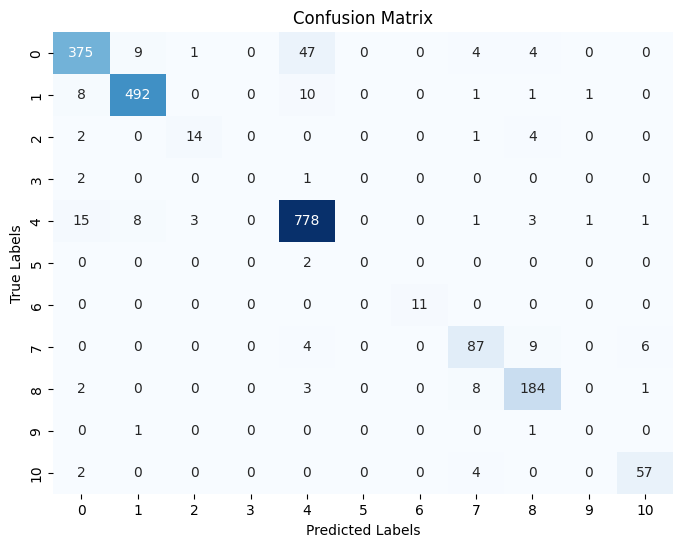

NameError: name 'precision' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# Create confusion matrix
y_text_test = test['categories__2'].str.lower()
predictions_dbncnn =test['pcategories__2']
# Calculate accuracy
accuracy = (y_text_test == predictions_dbncnn).mean()
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(y_text_test, predictions_dbncnn)

# Plot heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot heatmap for precision, recall, and F1 score
data = [[precision, recall, f1]]
metrics = ['Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(8, 4))
sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=metrics, yticklabels=False, cbar=False)
plt.title('Precision, Recall, and F1 Score')
plt.show()

In [ ]:
file_path = 'predictionsnew_92_1.csv'

# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
test.to_csv(file_path, index=False)

In [ ]:

test=pd.read_csv(r'predictionsfirstlevel.csv')
test=test.replace(np.nan, '',regex=True)

In [ ]:

leafnode=leafnode_extraction(train)
leafnode=[x.lower() for x in leafnode]
testleafnode=leafnode_extraction(test)
testleafnode=[x.lower() for x in testleafnode]
leafnodeval=leafnode_extraction(val)
leafnodeval=[x.lower() for x in leafnodeval]
train['leaf']=leafnode
test['leaf']=testleafnode
val['leaf']=leafnodeval
test.head()

# to train leafnode prediction
# extraction of train samples of particular level1 category

inp1=train.loc[train['categories__2']=='Computers & Accessories']
inp2=train.loc[train['categories__2']=='Accessories & Supplies']
inp3=train.loc[train['categories__2']=='GPS & Navigation']
inp4=train.loc[train['categories__2']=='eBook Readers & Accessories']
inp5=train.loc[train['categories__2']=='Car & Vehicle Electronics']
inp6=train.loc[train['categories__2']=='Camera & Photo']
inp7=train.loc[train['categories__2']=='Portable Audio & Video']
inp8=train.loc[train['categories__2']=='Cell Phones & Accessories']
inp9=train.loc[train['categories__2']=='Television & Video']
inp10=train.loc[train['categories__2']=='Home Audio']
inp11=train.loc[train['categories__2']=='Security & Surveillance']


val1=val.loc[train['categories__2']=='Computers & Accessories']
val2=val.loc[train['categories__2']=='Accessories & Supplies']
val3=val.loc[train['categories__2']=='GPS & Navigation']
val4=val.loc[train['categories__2']=='eBook Readers & Accessories']
val5=val.loc[train['categories__2']=='Car & Vehicle Electronics']
val6=val.loc[train['categories__2']=='Camera & Photo']
val7=val.loc[train['categories__2']=='Portable Audio & Video']
val8=val.loc[train['categories__2']=='Cell Phones & Accessories']
val9=val.loc[train['categories__2']=='Television & Video']
val10=val.loc[train['categories__2']=='Home Audio']
val11=val.loc[train['categories__2']=='Security & Surveillance']

#test
testinp1=test.loc[test['pcategories__2']=='computers & accessories']
testinp2=test.loc[test['pcategories__2']=='accessories & supplies']
testinp3=test.loc[test['pcategories__2']=='gps & navigation']
testinp4=test.loc[test['pcategories__2']=='ebook readers & accessories']
testinp5=test.loc[test['pcategories__2']=='car & vehicle electronics']
testinp6=test.loc[test['pcategories__2']=='camera & photo']
testinp7=test.loc[test['pcategories__2']=='portable audio & video']
testinp8=test.loc[test['pcategories__2']=='cell phones & accessories']
testinp9=test.loc[test['pcategories__2']=='television & video']
testinp10=test.loc[test['pcategories__2']=='home audio']
testinp11=test.loc[test['pcategories__2']=='security & surveillance']
#//////////////////////////////////////////

In [ ]:
len(testinp1)+len(testinp2)+len(testinp3)+len(testinp4)+len(testinp5)+len(testinp6)+len(testinp7)+len(testinp8)+len(testinp9)+len(testinp10)+len(testinp11)

2169

In [ ]:
def encode_labels(train_labels, test_labels, val_labels):
    # Combine labels from train, test, and validation sets
    all_labels = np.concatenate((train_labels, test_labels, val_labels), axis=0)

    # Initialize and fit the label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    encoded_labels_train = label_encoder.transform(train_labels)
    encoded_labels_train = to_categorical(encoded_labels_train, num_classes=len(label_encoder.classes_))

    encoded_labels_test = label_encoder.transform(test_labels)
    encoded_labels_test = to_categorical(encoded_labels_test, num_classes=len(label_encoder.classes_))
    encoded_val_labels = label_encoder.transform(val_labels)
    encoded_val_labels = to_categorical(encoded_val_labels, num_classes=len(label_encoder.classes_))
    return encoded_labels_train, encoded_labels_test, encoded_val_labels, label_encoder

def Load_images(inp):
    X_Images=[]
    for i in list(inp['image']):
        img=image.load_img(i,target_size=(200,200,3))
        img=image.img_to_array(img)
        img=img/255
        X_Images.append(img)
    x_images=np.array(X_Images)
    return x_images


In [ ]:
# Combine both models
def create_multi_modal_model(cnn_model, dbn_model,num_classes):
    combined_input = concatenate([cnn_model.output, dbn_model.output])
    combined = Dense(128, activation='relu')(combined_input)
    combined = Dropout(0.5)(combined)
    combined = Dense(64, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(combined)  # Adjust output layer based on the number of classes
    return Model(inputs=[cnn_model.input, dbn_model.input], outputs=output)

def cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,wp,size,X_val_img,X_val_encoded,encoded_labels_val):
    cnn_model = create_cnn_model()
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Instantiate DBN model for text
    input_dim_dbn = X_train_encoded.shape[1]
    dbn_model = create_dbn_model(input_dim_dbn)
    dbn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    multi_modal_model = create_multi_modal_model(cnn_model, dbn_model,num_classes)
    multi_modal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the multi-modal model using both image and text inputs
    multi_modal_model.fit([X_train_img, X_train_encoded], encoded_labels_train, epochs=ep, batch_size=size, validation_data=([X_val_img, X_val_encoded], encoded_labels_val))
    return multi_modal_model

In [ ]:
test.head()

,title,description,imUrl,price,brand,categories__1,categories__2,categories__3,categories__4,categories__5,categories__6,lemmatized_text,final_lemmatized_string,image,pcategories__2,leaf
0,Panasonic SC-AK29 Compact Stereo System (Disco...,"Equipped with a five-CD changer, Panasonic's S...",http://ecx.images-amazon.com/images/I/41QGRQSQ...,134.5,,Electronics,Home Audio,Compact Stereos,,,,"['panasonic', 'compact', 'stereo', 'system', '...",panasonic compact stereo system discontinued ...,test_images/test_images/0.jpg,home audio,compact stereos
1,JVC MXJ200 Compact Stereo System (Discontinued...,"JVC's MX-J200 compact stereo may be small, but...",http://ecx.images-amazon.com/images/I/41W6F65V...,134.5,,Electronics,Home Audio,Compact Stereos,,,,"['jvc', 'compact', 'stereo', 'system', 'discon...",jvc compact stereo system discontinued manufa...,test_images/test_images/1.jpg,home audio,compact stereos
2,Sennheiser RS4-9 On-Ear Wireless Headphone,Sennheiser's RS4-9 wireless headphones consist...,http://g-ecx.images-amazon.com/images/G/01/x-s...,134.5,,Electronics,Accessories & Supplies,Audio & Video Accessories,Headphones,,,"['sennheiser', 'wireless', 'headphone', 'sennh...",sennheiser wireless headphone sennheiser wire...,test_images/test_images/2.jpg,accessories & supplies,headphones
3,Pioneer VSX-D309 Audio/Video Receiver (Discont...,"With built-in Dolby Digital, DTS, and Dolby Pr...",http://ecx.images-amazon.com/images/I/41JTX248...,134.5,,Electronics,Home Audio,Stereo Components,Receivers & Amplifiers,Component Receivers,,"['pioneer', 'receiver', 'discontinued', 'manuf...",pioneer receiver discontinued manufacturer do...,test_images/test_images/3.jpg,home audio,component receivers
4,Pioneer VSX-108 Audio/Video Receiver (Disconti...,With 50 watts per channel and surround conveni...,http://ecx.images-amazon.com/images/I/41AJK34P...,134.5,,Electronics,Home Audio,Stereo Components,Receivers & Amplifiers,Component Receivers,,"['pioneer', 'receiver', 'discontinued', 'manuf...",pioneer receiver discontinued manufacturer wa...,test_images/test_images/4.jpg,home audio,component receivers


In [ ]:
#--------------------------------------------------------------------
# Instantiate DBN model for text
#Applying Model for each category__2 categories
# Model for category  'Computers & Accessories'


import gc
gc.collect()
print(' Result of Computers & Accessories:')
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp1['leaf'],testinp1['leaf'],val1['leaf'])
X_train_leaf1,X_test_leaf1,X_val_leaf1=tf_idf_vectorization(inp1,testinp1,val1)
X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf1, X_test_leaf1, X_val_leaf1)
input_dim_dbn = X_train_encoded.shape[1]
#test images loading
X_test_img=Load_images(testinp1)
X_train_img=Load_images(inp1)
X_val_img=Load_images(val1)
# Instantiate CNN model for image
# Instantiate DBN model for text
input_dim_dbn = X_train_encoded.shape[1]
num_classes = 186 # Set the input dimensions based on the DBN input shape
ep=50
size=5
model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

# Evaluate the multi-modal model
loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
print(f'Test Accuracy: {accuracy}')
predicted_probabilities= model.predict([X_test_img, X_test_encoded])
# Convert probabilities to class indices (argmax to get the index of the highest probability)
predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)




 Result of Computers & Accessories:
(1454, 5000)
(845, 5000)
Epoch 1/50
291/291 [==============================] - 2s 4ms/step - loss: 0.1051 - val_loss: 0.0094
Epoch 2/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 3/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 4/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 5/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 6/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 7/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 8/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 9/50
291/291 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 10/50
291/291 [==================

In [ ]:
# Display predicted labels
testinp1['pleaf']=predicted_labels
file_path = 'testinp1.csv'

# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp1.to_csv(file_path, index=False)

<ipython-input-27-3e524c413c8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp1['pleaf']=predicted_labels


In [ ]:
# Model for category  'Accessories & Supplies'

print(' Result of Accessories & Supplies:')

encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp2['leaf'],testinp2['leaf'],val2['leaf'])
X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp2,testinp2,val2)
X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
input_dim_dbn = X_train_encoded.shape[1]
#test images loading
X_test_img=Load_images(testinp2)
X_train_img=Load_images(inp2)
X_val_img=Load_images(val2)
input_dim_dbn = X_train_encoded.shape[1]
num_classes = 129 # Set the input dimensions based on the DBN input shape
ep=50
size=5
model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

# Evaluate the multi-modal model
loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
print(f'Test Accuracy: {accuracy}')
predicted_probabilities= model.predict([X_test_img, X_test_encoded])
# Convert probabilities to class indices (argmax to get the index of the highest probability)
predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)


# Display predicted labels
#testinp2['pleaf']=predicted_labels

 Result of Accessories & Supplies:
(707, 4228)
(406, 4228)
Epoch 1/50
142/142 [==============================] - 1s 4ms/step - loss: 0.2054 - val_loss: 0.0150
Epoch 2/50
142/142 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 3/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 5/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 6/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 7/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 8/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 9/50
142/142 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 10/50
142/142 [====================

In [ ]:
# Display predicted labels
#43
testinp2['pleaf']=predicted_labels
file_path = 'testinp2.csv'

# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp2.to_csv(file_path, index=False)

<ipython-input-66-35a3570095a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp2['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()

19576

In [ ]:
keras.backend.clear_session()

In [ ]:

print(' Result of GPS & Navigation:')

encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp3['leaf'],testinp3['leaf'],val3['leaf'])
X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp3,testinp3,val3)
X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
input_dim_dbn = X_train_encoded.shape[1]
#test images loading
X_test_img=Load_images(testinp3)
X_train_img=Load_images(inp3)
X_val_img=Load_images(val3)
input_dim_dbn = X_train_encoded.shape[1]
num_classes = 13 # Set the input dimensions based on the DBN input shape
ep=45
size=3
model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

# Evaluate the multi-modal model
loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
print(f'Test Accuracy: {accuracy}')
predicted_probabilities= model.predict([X_test_img, X_test_encoded])
# Convert probabilities to class indices (argmax to get the index of the highest probability)
predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)





 Result of GPS & Navigation:
(45, 943)
(11, 943)
Epoch 1/50
9/9 [==============================] - 1s 21ms/step - loss: 0.6806 - val_loss: 0.6607
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.6278 - val_loss: 0.5971
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.5155 - val_loss: 0.4853
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.3511 - val_loss: 0.3370
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1859 - val_loss: 0.2037
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0983 - val_loss: 0.1200
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0599 - val_loss: 0.0810
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.0631
Epoch 9/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0538
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0400 - val_lo

In [ ]:
#2727
# Display predicted labels
testinp3['pleaf']=predicted_labels
file_path = 'testinp3.csv'

# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp3.to_csv(file_path, index=False)

<ipython-input-80-667fc84ab99c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp3['pleaf']=predicted_labels


In [ ]:
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp4['leaf'],testinp4['leaf'],val4['leaf'])
len(label_encoder1.classes_)

13

In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()

785

In [ ]:
# Model for category  'eBook Readers & Accessories'

print(' Result of eBook Readers & Accessories:')

encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp4['leaf'],testinp4['leaf'],val4['leaf'])
X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp4,testinp4,val4)
X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
input_dim_dbn = X_train_encoded.shape[1]
#test images loading
X_test_img=Load_images(testinp4)
X_train_img=Load_images(inp4)
X_val_img=Load_images(val4)
input_dim_dbn = X_train_encoded.shape[1]
num_classes = 13 # Set the input dimensions based on the DBN input shape
ep=50
size=5
model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

# Evaluate the multi-modal model
loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
print(f'Test Accuracy: {accuracy}')
predicted_probabilities= model.predict([X_test_img, X_test_encoded])
# Convert probabilities to class indices (argmax to get the index of the highest probability)
predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

# Convert class indices back to original labels using inverse_transform of label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)




testinp4['pleaf']=predicted_labels

In [ ]:
print(testinp4.shape)

(0, 16)


45

In [ ]:
# Model for category  'Car & Vehicle Electronics'

print(' Result of car & vehicle electronics:')

if len(testinp5)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp5['leaf'],testinp5['leaf'],val5['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp5,testinp5,val5)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp5)
    X_train_img=Load_images(inp5)
    X_val_img=Load_images(val5)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 42 # Set the input dimensions based on the DBN input shape
    ep=50
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)



 Result of car & vehicle electronics:
(116, 1582)
(18, 1582)
Epoch 1/50
24/24 [==============================] - 1s 9ms/step - loss: 0.6382 - val_loss: 0.5620
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.3124 - val_loss: 0.2109
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0769 - val_loss: 0.0666
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0329 - val_loss: 0.0398
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0328
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0291
Epoch 7/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0271
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0260
Epoch 9/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0252
Epoch 10/50
24/24 [==============================] - 0s 4

In [ ]:
#52
# Display predicted labels

file_path = 'testinp5.csv'


# Display predicted labels
testinp5['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp5.to_csv(file_path, index=False)

<ipython-input-34-5cebff69f354>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp5['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
#encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp6['leaf'],testinp6['leaf'],val6['leaf'])
#len(label_encoder1.classes_)

10042

In [ ]:
# Model for category  'Camera & Photo'

print('Result of Camera & Photo:')

if len(testinp6)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp6['leaf'],testinp6['leaf'],val6['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp6,testinp6,val6)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp6)
    X_train_img=Load_images(inp6)
    X_val_img=Load_images(val6)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 111 # Set the input dimensions based on the DBN input shape
    ep=70
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)


Result of Camera & Photo:
(497, 4145)
(510, 4145)
Epoch 1/50
100/100 [==============================] - 2s 5ms/step - loss: 0.2761 - val_loss: 0.0216
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 8/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0104
Epoch 9/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 10/50
100/100 [=============================

2/2 [==============================] - 0s 4ms/step
Epoch 1/70
100/100 [==============================] - 4s 21ms/step - loss: 4.4754 - accuracy: 0.0966 - val_loss: 4.9665 - val_accuracy: 0.0169
Epoch 2/70
100/100 [==============================] - 2s 18ms/step - loss: 3.2600 - accuracy: 0.2173 - val_loss: 5.4039 - val_accuracy: 0.0678
Epoch 3/70
100/100 [==============================] - 2s 18ms/step - loss: 2.7272 - accuracy: 0.3682 - val_loss: 5.7944 - val_accuracy: 0.0847
Epoch 4/70
100/100 [==============================] - 2s 18ms/step - loss: 2.4319 - accuracy: 0.3944 - val_loss: 6.5268 - val_accuracy: 0.0847
Epoch 5/70
100/100 [==============================] - 2s 18ms/step - loss: 2.1266 - accuracy: 0.4708 - val_loss: 6.3635 - val_accuracy: 0.1356
Epoch 6/70
100/100 [==============================] - 2s 18ms/step - loss: 1.9605 - accuracy: 0.4970 - val_loss: 7.9856 - val_accuracy: 0.0678
Epoch 7/70
100/100 [==============================] - 2s 18ms/step - loss: 1.8781 - accurac

In [ ]:
#61
file_path = 'testinp6.csv'
# Display predicted labels
testinp6['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp6.to_csv(file_path, index=False)

<ipython-input-40-53c8077c66e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp6['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp7['leaf'],testinp7['leaf'],val7['leaf'])
len(label_encoder1.classes_)

74

In [ ]:
# Model for category  'Portable Audio & Video'

print(' Result of Portable Audio & Video:')

if len(testinp7)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp7['leaf'],testinp7['leaf'],val7['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp7,testinp7,val7)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp7)
    X_train_img=Load_images(inp7)
    X_val_img=Load_images(val7)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 74 # Set the input dimensions based on the DBN input shape
    ep=50
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

 Result of Portable Audio & Video:
(328, 3413)
(206, 3413)
Epoch 1/50
66/66 [==============================] - 1s 7ms/step - loss: 0.3634 - val_loss: 0.0729
Epoch 2/50
66/66 [==============================] - 0s 4ms/step - loss: 0.0234 - val_loss: 0.0287
Epoch 3/50
66/66 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.0227
Epoch 4/50
66/66 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0205
Epoch 5/50
66/66 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0195
Epoch 6/50
66/66 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0188
Epoch 7/50
66/66 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0182
Epoch 8/50
66/66 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0179
Epoch 9/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0174
Epoch 10/50
66/66 [==============================] - 0s 5ms

In [ ]:
#755
file_path = 'testinp7.csv'
# Display predicted labels
testinp7['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp7.to_csv(file_path, index=False)

<ipython-input-45-231a206e7c70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp7['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp8['leaf'],testinp8['leaf'],val8['leaf'])
len(label_encoder1.classes_)

5

In [ ]:
# Model for category  'Cell Phones & Accessories'

print(' Result of Cell Phones & Accessories:')

if len(testinp8)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp8['leaf'],testinp8['leaf'],val8['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp8,testinp8,val8)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp8)
    X_train_img=Load_images(inp8)
    X_val_img=Load_images(val8)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 5 # Set the input dimensions based on the DBN input shape
    ep=50
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

 Result of Cell Phones & Accessories:


In [ ]:

file_path = 'testinp8.csv'
# Display predicted labels
testinp8['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp8.to_csv(file_path, index=False)

<ipython-input-55-ae08a69dfee8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp8['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp9['leaf'],testinp9['leaf'],val9['leaf'])
len(label_encoder1.classes_)

30

In [ ]:
# Model for category  'Television & Video'
print(' Result of Television & Video:')
if len(testinp9)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp9['leaf'],testinp9['leaf'],val9['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp9,testinp9,val9)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp9)
    X_train_img=Load_images(inp9)
    X_val_img=Load_images(val9)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 30 # Set the input dimensions based on the DBN input shape
    ep=50
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

 Result of Television & Video:
(122, 2795)
(65, 2795)
Epoch 1/50
25/25 [==============================] - 1s 9ms/step - loss: 0.6235 - val_loss: 0.5433
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.1996 - val_loss: 0.1853
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0388 - val_loss: 0.0898
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0732
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0630
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0593
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.0558
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0542
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0212 - val_loss: 0.0534
Epoch 10/50
25/25 [==============================] - 0s 4ms/step

In [ ]:
#72
file_path = 'testinp9.csv'
# Display predicted labels
testinp9['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp9.to_csv(file_path, index=False)

<ipython-input-47-218184d33405>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp9['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp10['leaf'],testinp10['leaf'],val10['leaf'])
len(label_encoder1.classes_)

55

In [ ]:
# Model for category  'Home Audio'

print(' Result of Home Audio:')
if len(testinp10)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp10['leaf'],testinp10['leaf'],val10['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp10,testinp10,val10)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp10)
    X_train_img=Load_images(inp10)
    X_val_img=Load_images(val10)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 55 # Set the input dimensions based on the DBN input shape
    ep=50
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

 Result of Home Audio:
(230, 3134)
(106, 3134)
Epoch 1/50
46/46 [==============================] - 1s 6ms/step - loss: 0.4883 - val_loss: 0.1857
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.0369
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0270
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0235
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.0223
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.0209
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0205
Epoch 8/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0202
Epoch 9/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0201
Epoch 10/50
46/46 [==============================] - 0s 3ms/step - loss

In [ ]:
#56
file_path = 'testinp10.csv'
# Display predicted labels
testinp10['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp10.to_csv(file_path, index=False)

<ipython-input-55-38e11dd002e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp10['pleaf']=predicted_labels


In [ ]:
# Model for category  'GPS & Navigation'
import gc
gc.collect()
encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder1=encode_labels(inp11['leaf'],testinp11['leaf'],val11['leaf'])
len(label_encoder1.classes_)

11

In [ ]:
# Model for category  'Security & Surveillance'

print(' Result of Security & Surveillance:')
if len(testinp11)!=0:
    encoded_labels_train, encoded_labels_test, encoded_labels_val,label_encoder=encode_labels(inp11['leaf'],testinp11['leaf'],val11['leaf'])
    X_train_leaf,X_test_leaf,X_val_leaf=tf_idf_vectorization(inp11,testinp11,val11)
    X_train_encoded,X_test_encoded,X_val_encoded=train_denoising_autoencoder(X_train_leaf, X_test_leaf, X_val_leaf)
    input_dim_dbn = X_train_encoded.shape[1]
    #test images loading
    X_test_img=Load_images(testinp11)
    X_train_img=Load_images(inp11)
    X_val_img=Load_images(val11)
    input_dim_dbn = X_train_encoded.shape[1]
    num_classes = 11 # Set the input dimensions based on the DBN input shape
    ep=35
    size=5
    model= cnn_dbn(num_classes,X_train_img,X_train_encoded,encoded_labels_train,ep,size,X_val_img,X_val_encoded,encoded_labels_val)

    # Evaluate the multi-modal model
    loss, accuracy = model.evaluate([X_test_img, X_test_encoded], encoded_labels_test)
    print(f'Test Accuracy: {accuracy}')
    predicted_probabilities= model.predict([X_test_img, X_test_encoded])
    # Convert probabilities to class indices (argmax to get the index of the highest probability)
    predicted_class_indices = np.argmax(predicted_probabilities, axis=1)

    # Convert class indices back to original labels using inverse_transform of label_encoder
    predicted_labels = label_encoder.inverse_transform(predicted_class_indices)

 Result of Security & Surveillance:
(16, 465)
(2, 465)
Epoch 1/50
4/4 [==============================] - 1s 44ms/step - loss: 0.6900 - val_loss: 0.6780
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6728 - val_loss: 0.6611
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6520 - val_loss: 0.6411
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6262 - val_loss: 0.6168
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.5893 - val_loss: 0.5881
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.5467 - val_loss: 0.5528
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.4958 - val_loss: 0.5113
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 0.4308 - val_loss: 0.4640
Epoch 9/50
4/4 [==============================] - 0s 10ms/step - loss: 0.3785 - val_loss: 0.4123
Epoch 10/50
4/4 [==============================] - 0s 10ms/step - loss: 

In [ ]:
#55
file_path = 'testinp11.csv'
# Display predicted labels
testinp11['pleaf']=predicted_labels
# Save the modified 'test' DataFrame to a CSV file without the DataFrame index
testinp11.to_csv(file_path, index=False)

<ipython-input-60-6cb33d7c7699>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testinp11['pleaf']=predicted_labels


In [ ]:
testinp11.head()

,title,description,imUrl,price,brand,categories__1,categories__2,categories__3,categories__4,categories__5,categories__6,lemmatized_text,final_lemmatized_string,image,pcategories__2,leaf,pleaf
1508,Minolta APS Adapter Ad-10 For Dimage Scan Dual...,,http://ecx.images-amazon.com/images/I/21GYT3DE...,134.5,,Electronics,Camera & Photo,Accessories,Batteries & Chargers,Adapters,,"['minolta', 'aps', 'adapter', 'dimage', 'scan'...",minolta aps adapter dimage scan dual amp scan...,test_images/test_images/1508.jpg,security & surveillance,adapters,radio scanners
1985,"Altec Lansing XA3051 5.1 Speakers (6-Speaker, ...",,http://ecx.images-amazon.com/images/I/41M7MZ4P...,134.5,,Electronics,Computers & Accessories,Cables & Accessories,Computer Speakers,,,"['altec', 'lansing', 'speaker', 'black', 'amp'...",altec lansing speaker black amp silver,test_images/test_images/1985.jpg,security & surveillance,computer speakers,radio scanners


In [ ]:
len(testinp1)+len(testinp2)+len(testinp3)+len(testinp4)+len(testinp5)+len(testinp6)+len(testinp7)+len(testinp8)+len(testinp9)+len(testinp10)+len(testinp11)

2378

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

file_paths = [
    'testinp1.csv',  # Replace 'file1.csv' with your actual file paths
    'testinp2.csv','testinp3.csv','testinp5.csv','testinp6.csv','testinp7.csv','testinp9.csv','testinp10.csv','testinp11.csv'

]

# Initialize an empty list to store DataFrames
dfs = []

# Read each CSV file and append its contents to the 'dfs' list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames in the 'dfs' list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)  # ignore_index=True resets the indices

# Calculate accuracy between 'leaf' and 'pleaf' columns
accuracy = accuracy_score(combined_df['leaf'], combined_df['pleaf']) * 100
print("Overall accuracy between 'leaf' and 'pleaf' columns:", accuracy)
precision = precision_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')
recall = recall_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')
f1 = f1_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Overall accuracy between 'leaf' and 'pleaf' columns: 63.43937298294144
Precision: 0.6534927811798056
Recall: 0.6343937298294144
F1 Score: 0.623747736585257


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

file_paths = [
    'testinp1.csv',  # Replace 'file1.csv' with your actual file paths
    'testinp2.csv','testinp3.csv','testinp5.csv','testinp6.csv','testinp7.csv','testinp9.csv','testinp10.csv','testinp11.csv'

]

# Initialize an empty list to store DataFrames
dfs = []

# Read each CSV file and append its contents to the 'dfs' list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames in the 'dfs' list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)  # ignore_index=True resets the indices

# Calculate accuracy between 'leaf' and 'pleaf' columns
accuracy = accuracy_score(combined_df['leaf'], combined_df['pleaf']) * 100
print("Overall accuracy between 'leaf' and 'pleaf' columns:", accuracy)
precision = precision_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')
recall = recall_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')
f1 = f1_score(combined_df['leaf'], combined_df['pleaf'], average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Overall accuracy between 'leaf' and 'pleaf' columns: 61.50299677270632
Precision: 0.6485690629872101
Recall: 0.6150299677270632
F1 Score: 0.6047127008664541


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
type(dbn_df['leaf'])

Overall accuracy between 'leaf' and 'pleaf' columns: 62.01014292300599

In [ ]:
file_path = 'destination.csv'

# Save the DataFrame to a CSV file
combined_df.to_csv(file_path, index=False)

In [ ]:
def train_denoising_autoencoder(X_train, X_new, X_new_val):
    # Build Denoising Autoencoder (DAE)
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dropout(0.5)(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    dae = Model(input_layer, decoded)
    dae.compile(optimizer='adam', loss='binary_crossentropy')
    dae.fit(X_train.toarray(), X_train.toarray(), epochs=40, batch_size=5, validation_data=(X_new_val.toarray(), X_new_val.toarray()))

    # Extract features using DAE
    encoder = Model(input_layer, encoded)
    X_train_encoded = encoder.predict(X_train.toarray())
    X_test_encoded = encoder.predict(X_new.toarray())
    X_val_encoded = encoder.predict(X_new_val.toarray())
    return X_train_encoded, X_test_encoded, X_val_encoded